## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Step 1: Compute the camera calibration using chessboard images

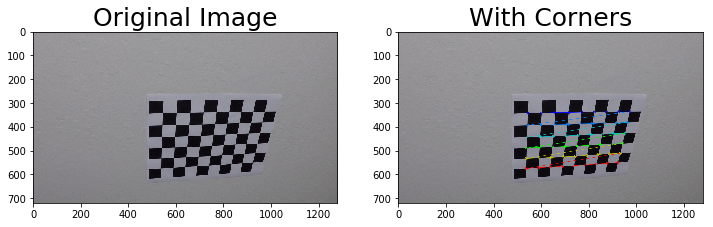

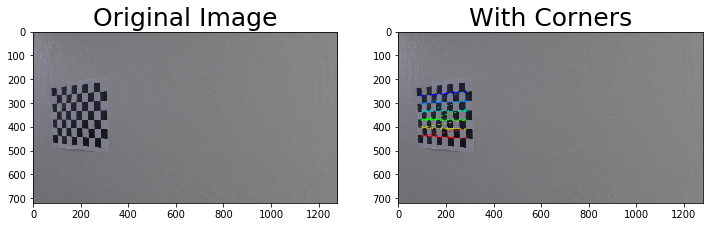

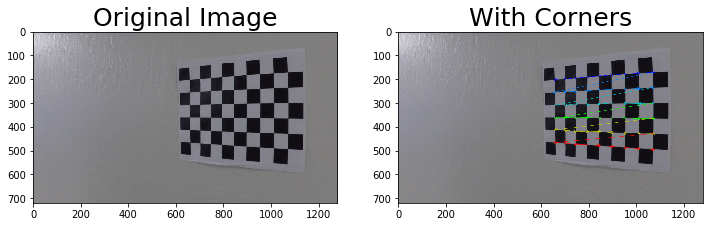

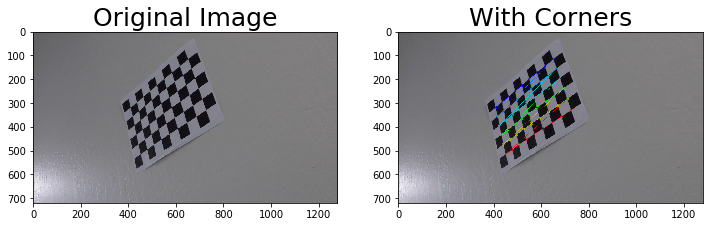

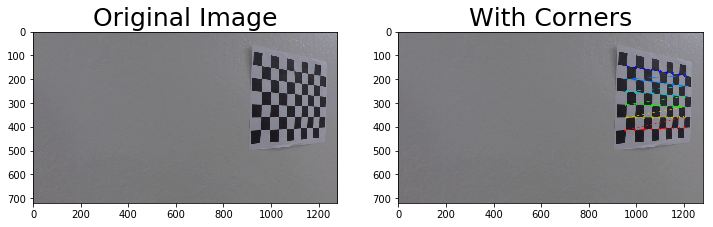

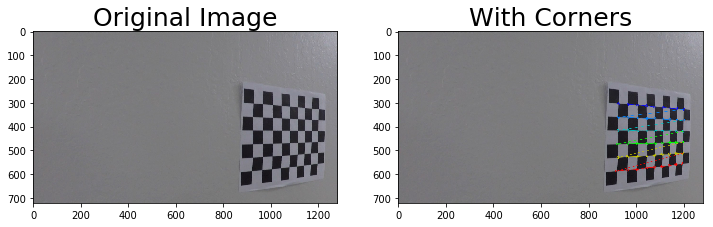

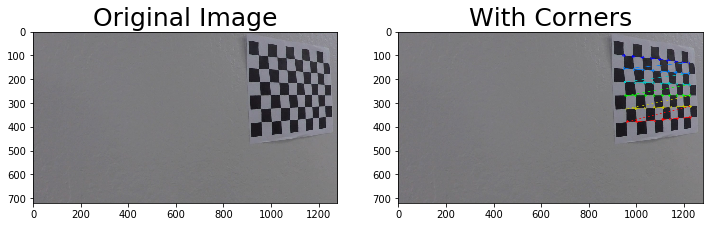

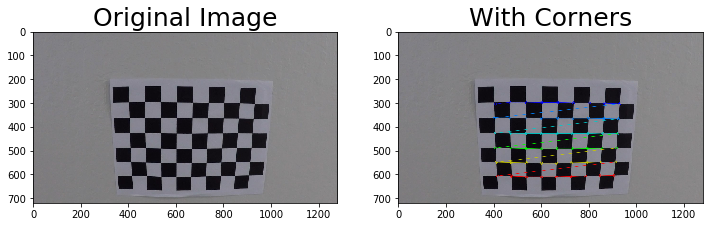

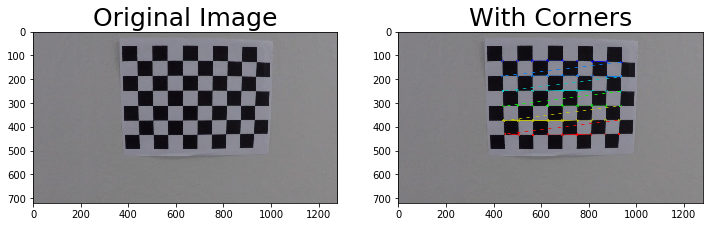

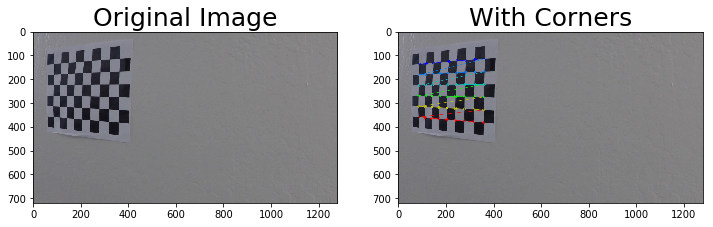

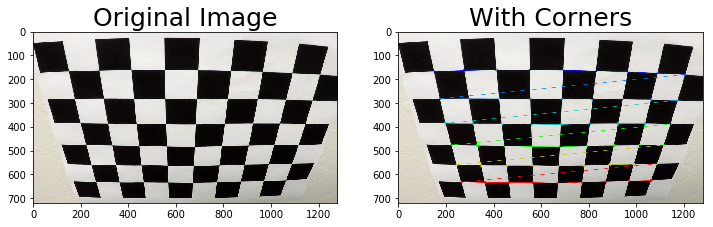

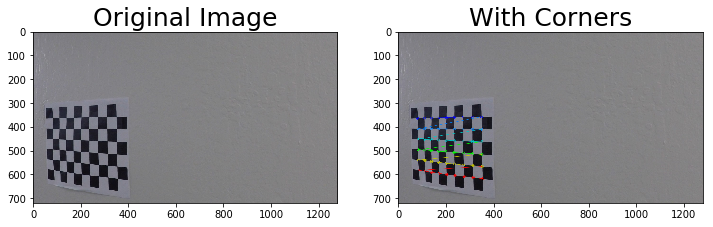

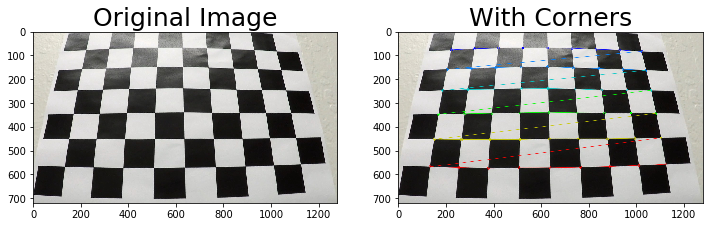

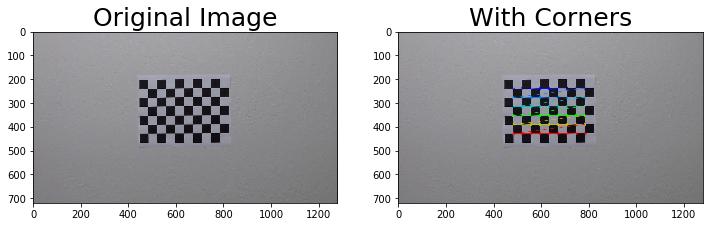

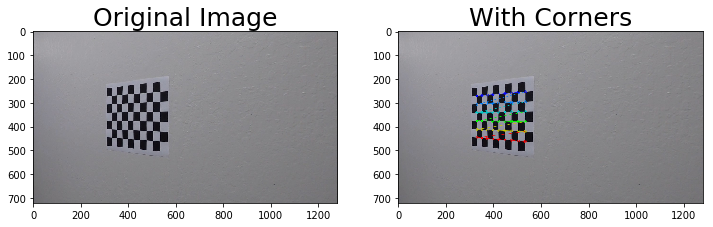

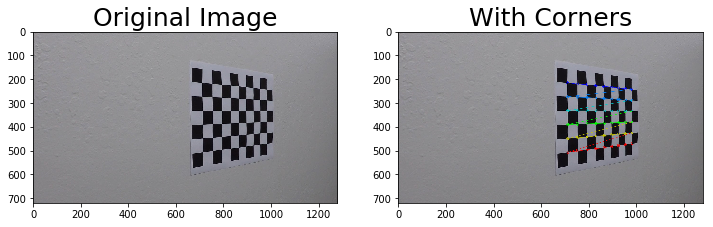

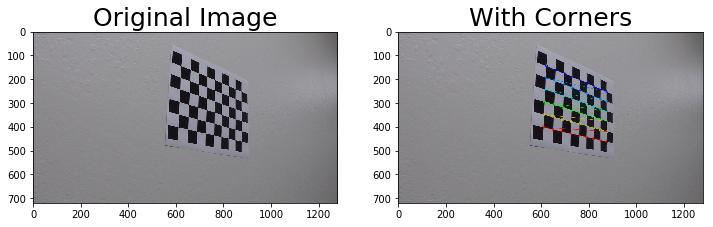

In [10]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
#objp = np.array([objp])

image_count = 0

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for frame in images:
    #img = cv2.imread(fname)
    img = mpimg.imread(frame)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    gray_shape = gray.shape[::-1]
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If found, add object points, image points
    if ret == True:
        #corners = np.array([[corner for [corner] in corners]])
        #print(image_count, len(corners))
        
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        image_count +=1
        
        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        #f.tight_layout()
        ax1.imshow(mpimg.imread(frame))
        ax1.set_title('Original Image', fontsize=25)
        ax2.imshow(img)
        ax2.set_title('With Corners', fontsize=25)
        #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
        plt.show()

## Step 2: Apply the distortion correction to RAW images

In [41]:
#img = mpimg.imread('../test_images/straight_lines1.jpg')
#img = mpimg.imread('../test_images/straight_lines2.jpg')

# Make a list of test images
images = glob.glob('../test_images/test*.jpg')

In [42]:
def undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img

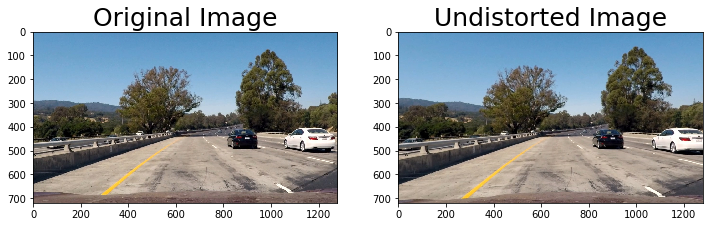

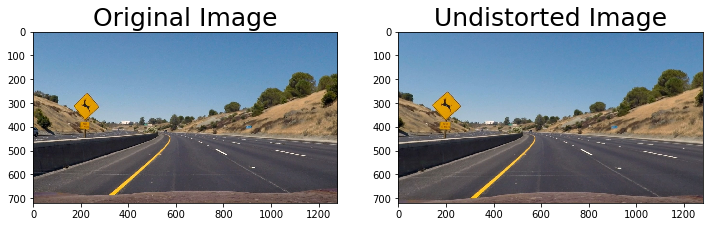

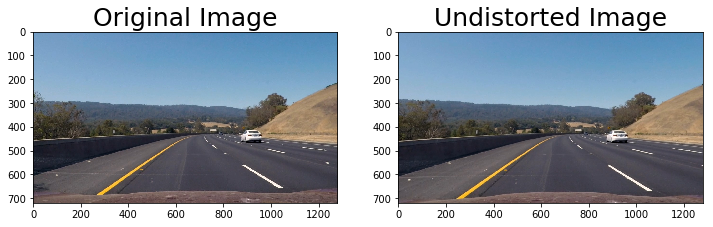

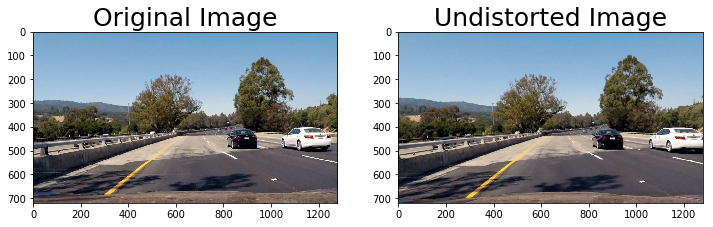

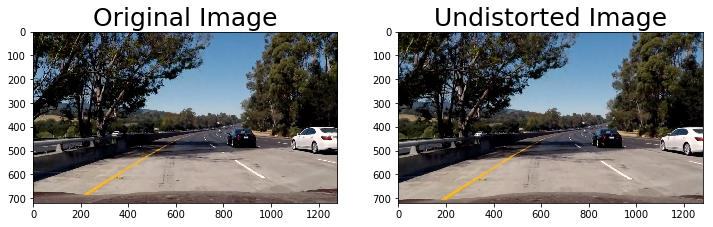

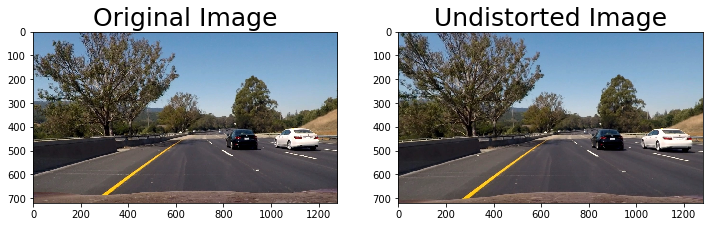

In [43]:
for image in images:
    img = mpimg.imread(image)
    undist_img = undistort(img, objpoints, imgpoints)

    # Plot the results
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(undist_img)
    ax2.set_title('Undistorted Image', fontsize=25)

    plt.show()

## Step 3: Thresholding images with color transforms and gradients.

In [47]:
# Calculate directional gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, abs_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Thresholding
    grad_binary[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1

    # Return the result
    return grad_binary

# Calculate gradient magnitude
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    # Return the result
    return mag_binary

# Calculate gradient direction
def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    
    # Return the result
    return dir_binary

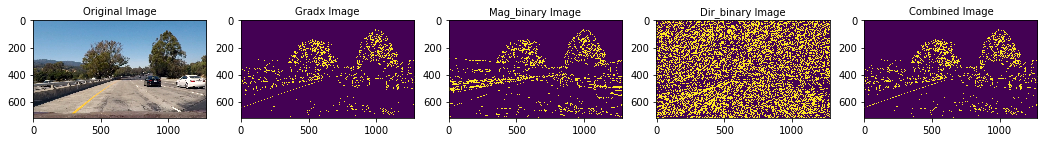

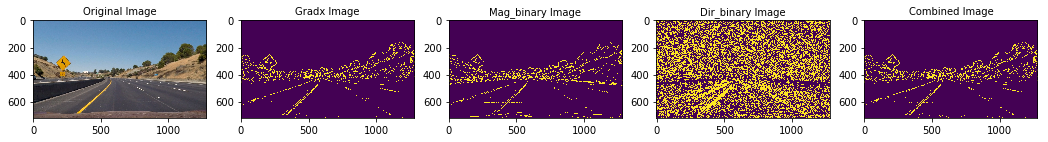

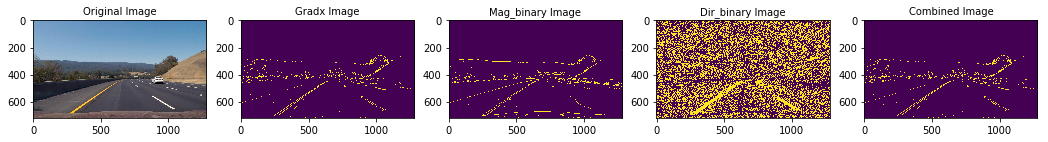

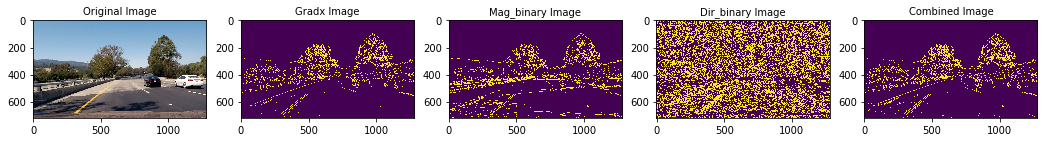

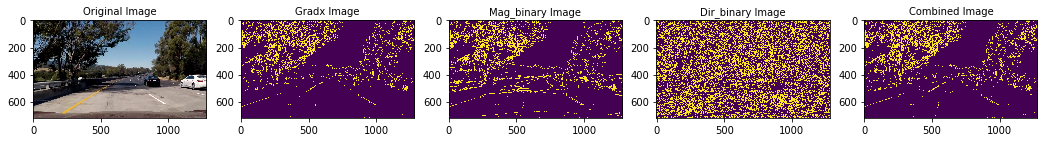

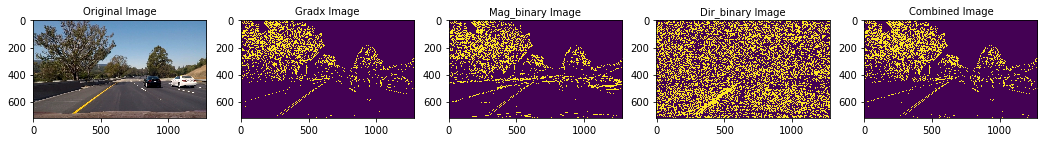

In [56]:
for image in images:
    img = mpimg.imread(image)
    undist_img = undistort(img, objpoints, imgpoints)

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(undist_img, orient='x', sobel_kernel=3, abs_thresh=(20, 100))
    grady = abs_sobel_thresh(undist_img, orient='y', sobel_kernel=3, abs_thresh=(20, 100))
    mag_binary = mag_thresh(undist_img, sobel_kernel=3, mag_thresh=(30, 100))
    dir_binary = dir_threshold(undist_img, sobel_kernel=15, dir_thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Plot the results
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(18, 6))

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(gradx)
    ax2.set_title('Gradx Image', fontsize=10)
    ax3.imshow(mag_binary)
    ax3.set_title('Mag_binary Image', fontsize=10)
    ax4.imshow(dir_binary)
    ax4.set_title('Dir_binary Image', fontsize=10)
    ax5.imshow(combined)
    ax5.set_title('Combined Image', fontsize=10)
    
    plt.show()